In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [16]:
df = pd.read_csv('payment_data.csv')

In [17]:
df.head()

,_time,Amount,paymentType,eventTypes
0,2023-01-01 00:00:00,3322.612322,Refund,Completed
1,2023-01-01 00:00:01,11094.614481,Debit,Pending
2,2023-01-01 00:00:02,11471.330996,Debit,Pending
3,2023-01-01 00:00:03,15755.134301,Credit,Completed
4,2023-01-01 00:00:04,14671.195620,Credit,Completed


In [18]:
df['_time'] = pd.to_datetime(df['_time'])
df.set_index('_time', inplace=True)
df_daily = df.resample('D').size().reset_index(name='transactions')
df_daily.columns = ['ds', 'y']


# SARIMAX

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00838D+01    |proj g|=  1.31435D-01

At iterate    5    f=  1.00381D+01    |proj g|=  2.03556D-02

At iterate   10    f=  1.00273D+01    |proj g|=  1.59409D-03

At iterate   15    f=  1.00271D+01    |proj g|=  1.31506D-04

At iterate   20    f=  1.00271D+01    |proj g|=  4.14614D-04

At iterate   25    f=  1.00265D+01    |proj g|=  1.28455D-02

At iterate   30    f=  9.98714D+00    |proj g|=  8.87835D-02

At iterate   35    f=  9.97830D+00    |proj g|=  3.10304D-03

At iterate   40    f=  9.97802D+00    |proj g|=  5.30205D-04

At iterate   45    f=  9.97798D+00    |proj g|=  3.69420D-04

At iterate   50    f=  9.97797D+00    |proj g|=  2.19355D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/pratik/opt/miniconda3/envs/SETU/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


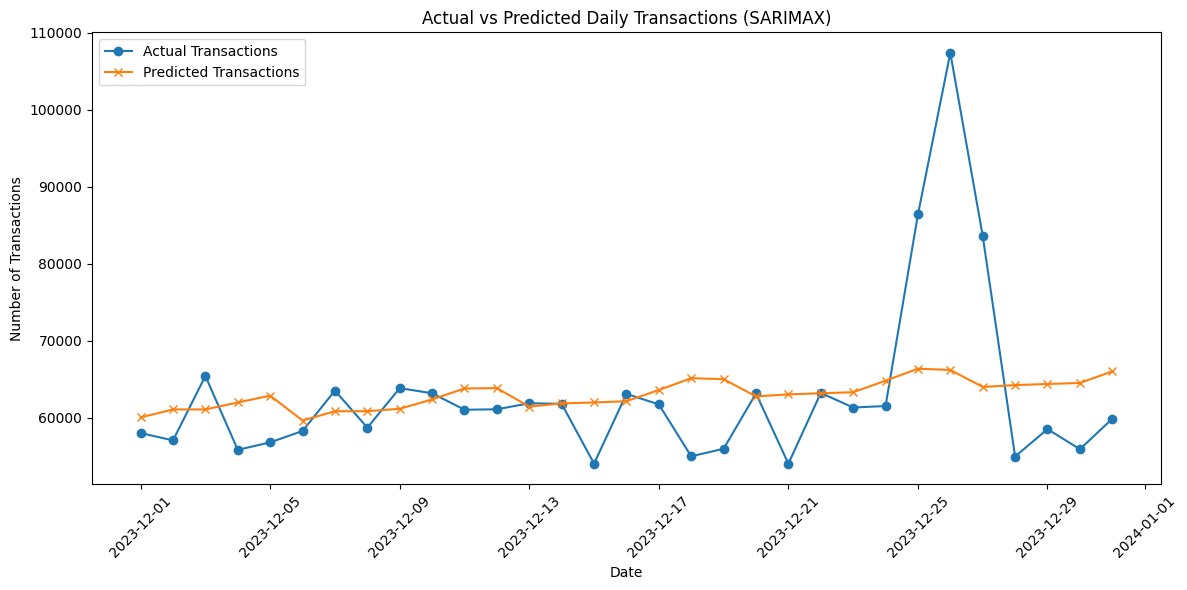

MAE: 6248.98, RMSE: 10183.30


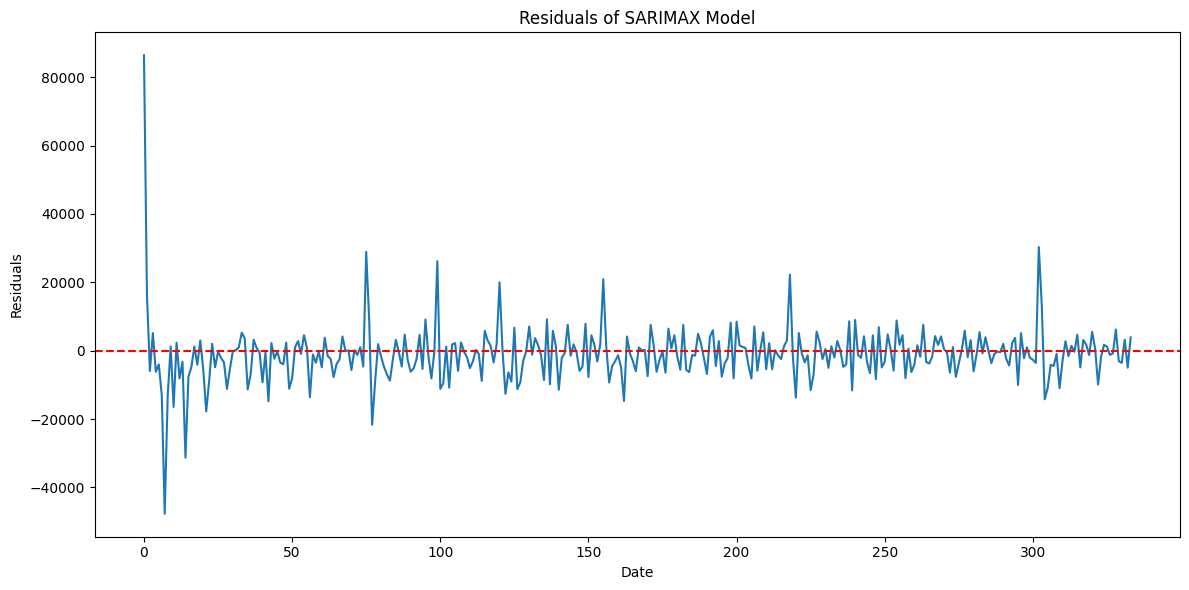

In [22]:
# Split the data into training and testing sets
train = df_daily[df_daily['ds'] < '2023-12-01']  # Train until November
test = df_daily[df_daily['ds'] >= '2023-12-01']  # Test on December

# Define the SARIMAX model with improved seasonal order
# Adjust (p, d, q) and seasonal_order (P, D, Q, S) as needed
model = SARIMAX(train['y'],
                order=(1, 1, 1),         # Adjust AR, I, MA terms
                seasonal_order=(1, 1, 1, 7))  # (P, D, Q, S), S=7 for weekly seasonality
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

# Prepare a DataFrame to compare predicted and actual
results = pd.DataFrame({
    'Date': test['ds'],
    'Actual': test['y'],
    'Predicted': predictions
})

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual'], label='Actual Transactions', marker='o')
plt.plot(results['Date'], results['Predicted'], label='Predicted Transactions', marker='x')
plt.title('Actual vs Predicted Daily Transactions (SARIMAX)')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate performance metrics
mae = np.mean(np.abs(results['Actual'] - results['Predicted']))  # Mean Absolute Error
mse = np.mean((results['Actual'] - results['Predicted']) ** 2)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

# Check residuals to evaluate model fit
residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


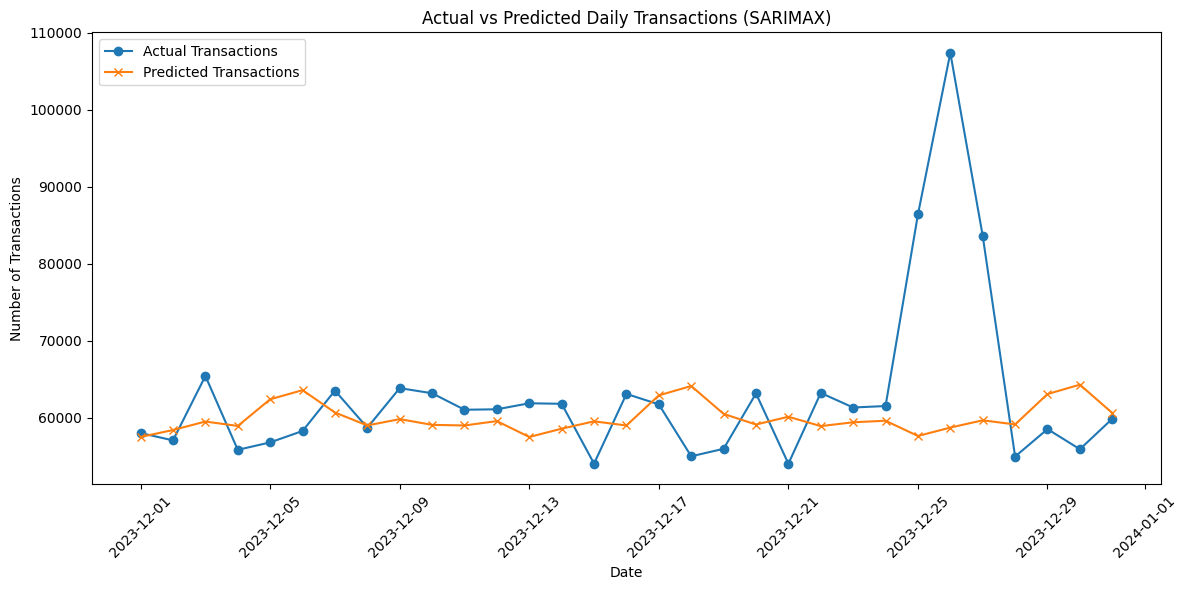

MAE: 6652.28, RMSE: 11772.30


In [21]:
plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual'], label='Actual Transactions', marker='o')
plt.plot(results['Date'], results['Predicted'], label='Predicted Transactions', marker='x')
plt.title('Actual vs Predicted Daily Transactions (SARIMAX)')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate performance metrics
mae = np.mean(np.abs(results['Actual'] - results['Predicted']))  # Mean Absolute Error
mse = np.mean((results['Actual'] - results['Predicted']) ** 2)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

# PROPHET

16:28:44 - cmdstanpy - INFO - Chain [1] start processing
16:28:44 - cmdstanpy - INFO - Chain [1] done processing


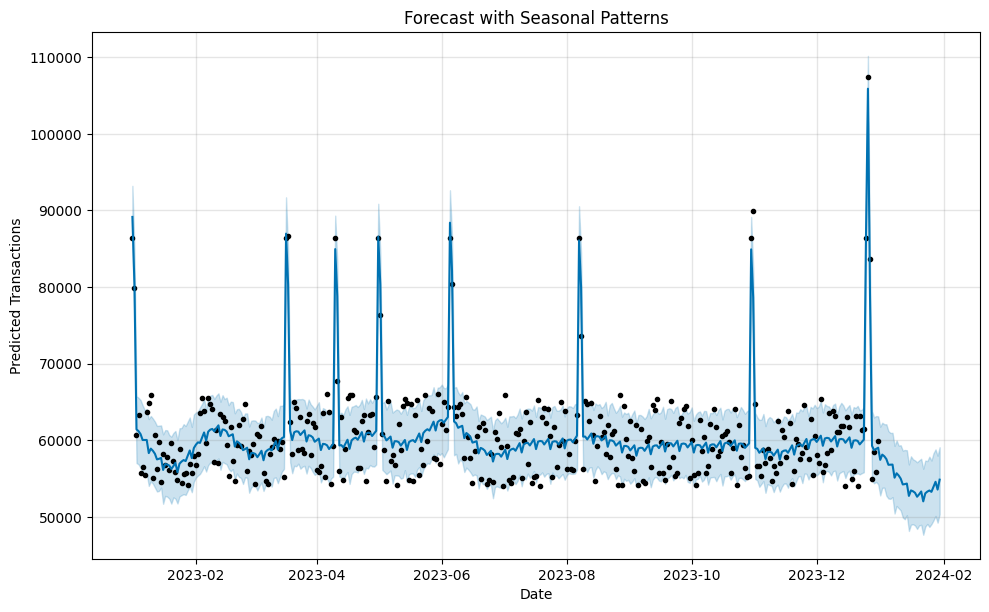

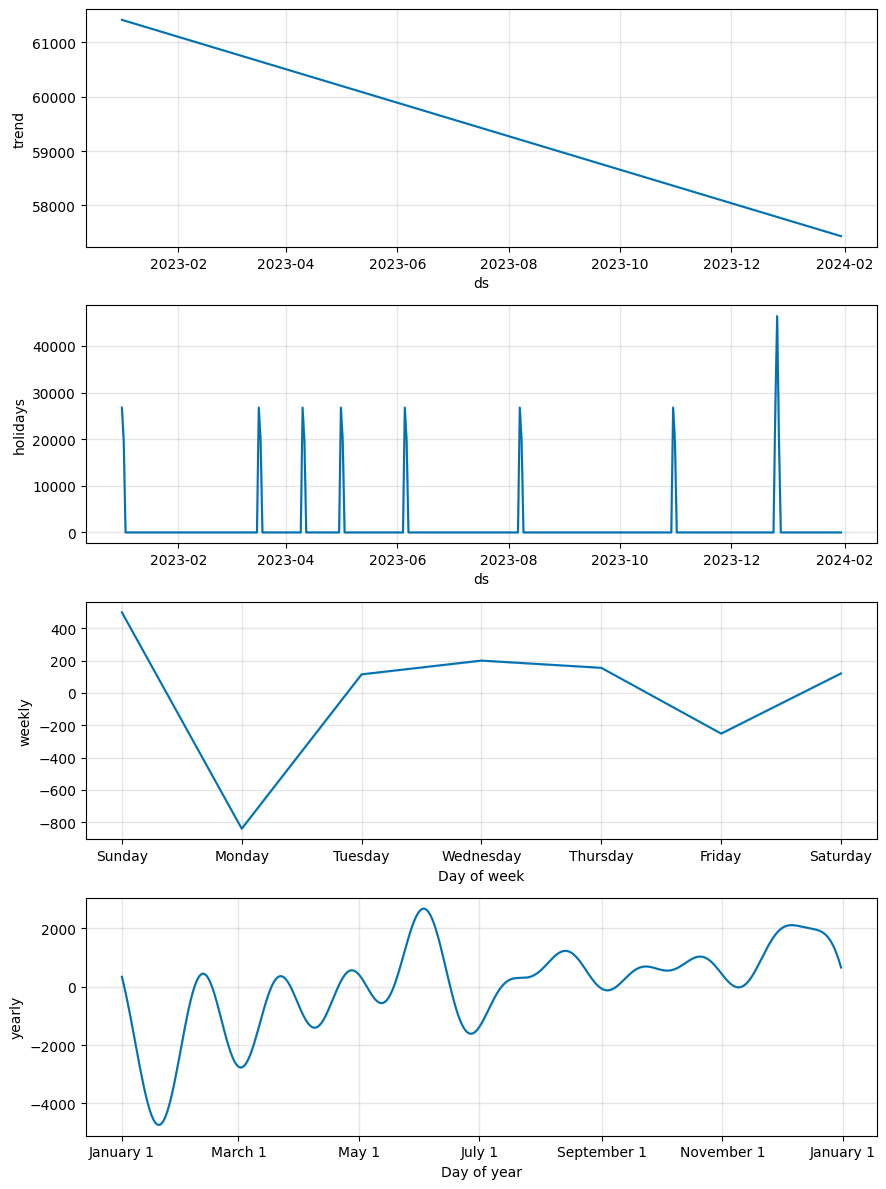

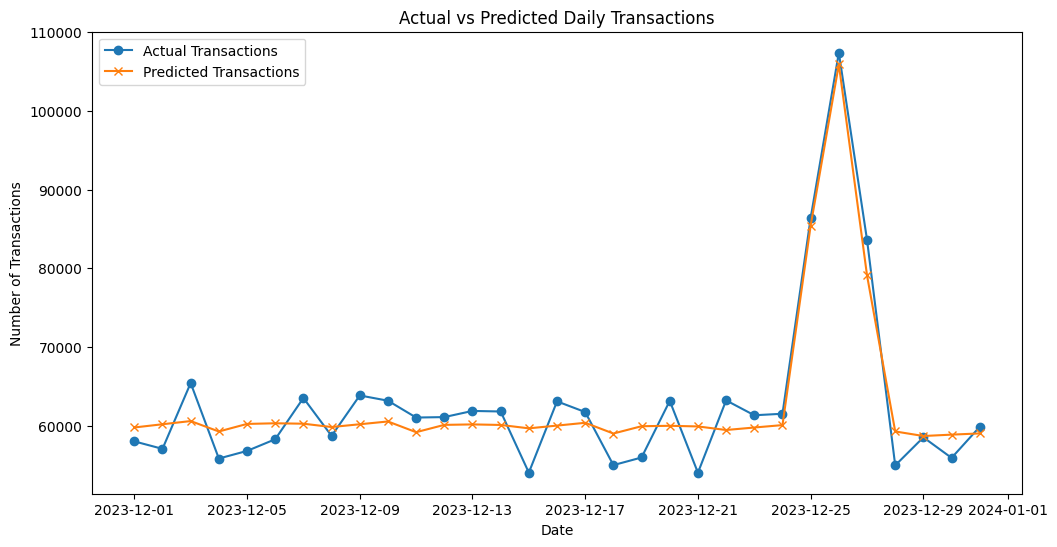

In [14]:
# Define a DataFrame for holidays
holidays = pd.DataFrame({
    'holiday': 'Irish Holidays',
    'ds': pd.to_datetime(['2023-01-01', '2023-03-17', '2023-04-10', '2023-05-01', 
                          '2023-06-05', '2023-08-07', '2023-10-30', '2023-12-25', 
                          '2023-12-26']),
    'lower_window': 0,
    'upper_window': 1,
})

# Initialize the model with holidays and increased seasonalities
model = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True)
model.add_seasonality(name='yearly', period=365, fourier_order=10)

# Fit the model
model.fit(df_daily)

# Create a future DataFrame
future = model.make_future_dataframe(periods=30)  # Adjust based on your test period
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast with Seasonal Patterns')
plt.xlabel('Date')
plt.ylabel('Predicted Transactions')
plt.show()

# Plot seasonal components
fig2 = model.plot_components(forecast)
plt.show()

# Evaluate predictions with actuals
results = df_daily[df_daily['ds'] >= '2023-12-01'].merge(forecast[['ds', 'yhat']], on='ds', how='left')
plt.figure(figsize=(12, 6))
plt.plot(results['ds'], results['y'], label='Actual Transactions', marker='o')
plt.plot(results['ds'], results['yhat'], label='Predicted Transactions', marker='x')
plt.title('Actual vs Predicted Daily Transactions')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend()
plt.show()